# Big data - 2. zh

## Beolvasás

In [1]:
import pandas as pd

df = pd.read_csv('imdb_2k.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,NaN,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Tisztítás, átalakítás

In [2]:
df.isnull().sum()

review       2
sentiment    0
dtype: int64

In [3]:
df.dropna(inplace=True)
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [4]:
df['text_len'] = df.apply(lambda x: len(x['review']), axis=1)
df.head()

,review,sentiment,text_len
0,One of the other reviewers has mentioned that ...,positive,1761
1,A wonderful little production. <br /><br />The...,positive,998
2,I thought this was a wonderful way to spend ti...,positive,926
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317
5,"Probably my all-time favorite movie, a story o...",positive,656


In [5]:
df = df[df['text_len'] > 10]
df.count()

review       1995
sentiment    1995
text_len     1995
dtype: int64

## Naive-Bayes osztályozás

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


feature_data = df['review'].copy()
label_data = df['sentiment'].copy()

print(feature_data.shape[0])
print(label_data.shape[0])

test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, random_state=42)

print(y_test.value_counts())

1995
1995
sentiment
negative    107
positive     93
Name: count, dtype: int64


In [7]:
countVectorizerModel = make_pipeline(CountVectorizer(), MultinomialNB())
countVectorizerModel.fit(X_train, y_train)
countVectorizerPredictedSentiments = countVectorizerModel.predict(X_test)
countVectorizerPredictedSentiments[:5]

array(['positive', 'positive', 'negative', 'negative', 'negative'],
      dtype='<U8')

In [8]:
TfidfVectorizerModel = make_pipeline(TfidfVectorizer(), MultinomialNB())
TfidfVectorizerModel.fit(X_train, y_train)
TfidfVectorizerPredictedSentiments = TfidfVectorizerModel.predict(X_test)
TfidfVectorizerPredictedSentiments[:5]

array(['positive', 'positive', 'negative', 'negative', 'negative'],
      dtype='<U8')

In [9]:
from sklearn.metrics import accuracy_score

accuracy1 = accuracy_score(countVectorizerPredictedSentiments, y_test)

print("Accuracy:", accuracy1)

accuracy2 = accuracy_score(TfidfVectorizerPredictedSentiments, y_test)

print("Accuracy:", accuracy2)

Accuracy: 0.81
Accuracy: 0.855


A második modell valóban pontosabb.

## KNN osztályozás 

In [10]:
from sklearn.neighbors import KNeighborsClassifier 

Ks = [i for i in range(1, 24) if i % 2 == 1]
KNeighbourAccuracies = []

bestKNeighbours = (None, 0)

for i in Ks:
    model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(i))
    model.fit(X_train, y_train)
    
    accuracy_score = model.score(X_test, y_test)
    KNeighbourAccuracies.append(accuracy_score)
    
    if accuracy_score > bestKNeighbours[1]:
        bestKNeighbours = (model, accuracy_score)
    
KNeighbourAccuracies

[0.68, 0.635, 0.62, 0.625, 0.65, 0.66, 0.675, 0.67, 0.645, 0.645, 0.65, 0.655]

In [11]:
bestKNeighbours

(Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))]),
 0.68)

## Kiértékelés

Elnézést ezért a spagetti kódért én se vagyok rá büszke.

In [12]:
better_bayes = countVectorizerModel if accuracy1 > accuracy2 else TfidfVectorizerModel
best_model = better_bayes if accuracy1 > bestKNeighbours[1] or accuracy2 > bestKNeighbours[1] else bestKNeighbours[0]
best_model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [13]:
best_model.predict(["Masterpiece."])

array(['positive'], dtype='<U8')

In [14]:
best_model.predict(["Very bad acting."])

array(['negative'], dtype='<U8')

## Vizualizáció

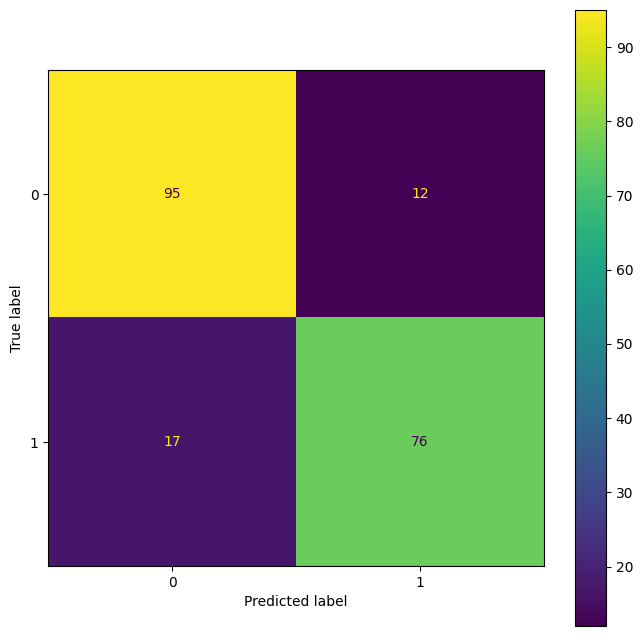

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=list(label_data.unique()).sort())
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)

C:\Users\bb200\AppData\Local\Temp\ipykernel_9092\1471395388.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(Ks)


<BarContainer object of 12 artists>

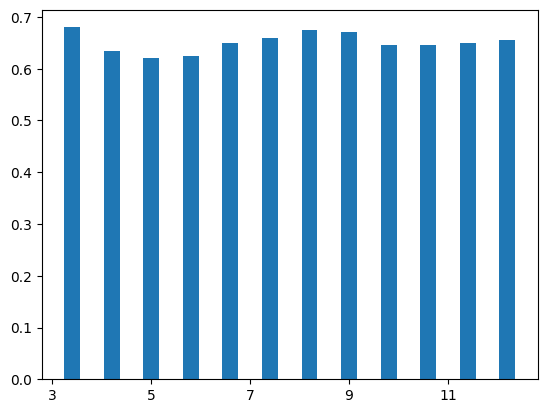

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xticklabels(Ks)
ax1.bar(x=Ks, height=KNeighbourAccuracies, label=Ks)